The cross-species integration pipeline for mouse and human lung datasets.
Step 1, we aligned mouse gene symbol with human gene symbol according to the human-mouse homologous gene table provided by MGI database (www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt). <br>
Step 2, seurat canonical correlation analysis (PMID: 29608179)principal component analysis (PCA) was performed on the combined mouse and human data, jointly embedding the cells into 40 canonical componentsprincipal components using with highly variable genes with using sc.pp.highly_variable_genes function (min_mean=0.0125, max_mean=3, min_disp=0.7). <br>
Step 3, the Harmony algorithm (PMID: 31740819) was applied to the CCA components to correct for batch effects. These batch-corrected Harmony components were used for visualization with UMAP. 

In [2]:
import sys,warnings
sys.path.append('./DevEndo/') # change to the path where devendo.py stript located.
import devendo as de
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata, re,os
import scanpy.external as sce
from scipy.sparse import csr_matrix,csc_matrix, find
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
sc.settings.set_figure_params(dpi=100, facecolor='white')
pd.set_option("display.max_rows", 40)
pd.set_option("display.precision", 2)

## 1. Load developmental lung datasets of human and mouse

The human developmental lung dataset was obtain from paper [A human fetal lung cell atlas uncovers proximaldistal gradients of differentiation and key regulators of epithelial fates, Cell 2022](https://doi.org/10.1016/j.cell.2022.11.005). Here I have translated the mouse gene symbol to human gene symbol using [MGI homologous genes database ](www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt). Only the genes shared by two species were retained for further analysis.

In [3]:
# The human and mouse datasets were merged together
adata = sc.read_h5ad('DATA/Developmental_lung_of_human_and_mouse.h5ad')

In [3]:
adata.obs

,embryonic_period,gender,subtype,Phase,n_counts,n_genes,mouse_stage,organ,human_stage,dataset,species,maincelltype
AACTGGTGTCCGCTGA-5891STDY8062349,E16.5,M,EC_APLNR+,Canalicular,3552.0,1966,16.5,NaN,18.0,Human,hsapiens,Endothelial cells
AAGGAGCCAAGACACG-5891STDY8062349,E16.5,M,EC_APLNR+,Canalicular,6687.0,2924,16.5,NaN,18.0,Human,hsapiens,Endothelial cells
ACACCCTGTGTTGGGA-5891STDY8062349,E15.0,M,EC_Venous,Canalicular,5885.0,2620,15.0,NaN,18.0,Human,hsapiens,Endothelial cells
ACACTGACATAGGATA-5891STDY8062349,E15.0,M,EC_Arterial,Canalicular,16500.0,4944,15.0,NaN,18.0,Human,hsapiens,Endothelial cells
ACATACGAGTAGCCGA-5891STDY8062349,E16.0,M,EC_APLNR+,Canalicular,5958.0,2796,16.0,NaN,18.0,Human,hsapiens,Endothelial cells
...,...,...,...,...,...,...,...,...,...,...,...,...
E18.5_20200228-8_TTTATGCAGAGGTCAC,E18.5,female,MES_Smooth muscle cells,Saccular,12462.0,4140,18.5,Lung,18.0,Mouse,mmusculus,Mesenchymal cells
E18.5_20200228-8_TTTCACAAGAAGCCTG,E18.5,female,MES_Smooth muscle cells,Saccular,7448.0,3299,18.5,Lung,15.0,Mouse,mmusculus,Mesenchymal cells
E18.5_20200228-8_TTTCACAAGATGCTGG,E18.5,female,MES_Fibroblast,Saccular,11745.0,3663,18.5,Lung,22.0,Mouse,mmusculus,Mesenchymal cells
E18.5_20200228-8_TTTGGTTAGAGGTCGT,E18.5,female,MES_Fibroblast,Saccular,7891.0,2918,18.5,Lung,22.0,Mouse,mmusculus,Mesenchymal cells


In [4]:
adata.var

,symbol,mean_counts
A1BG,A1bg,1.00e-12
A1CF,A1cf,3.54e-04
A2M,A2m,2.01e-02
A2ML1,A2ml1,9.48e-03
A3GALT2,A3galt2,1.27e-02
...,...,...
ZNF781,D130040H23Rik,5.53e-02
ZNF790,Zfp790,2.76e-02
ZNF791,Zfp791,1.02e-02
ZNF8,Zfp128,1.09e-02


In [5]:
adata

AnnData object with n_obs × n_vars = 90342 × 16550
    obs: 'embryonic_period', 'gender', 'subtype', 'Phase', 'n_counts', 'n_genes', 'mouse_stage', 'organ', 'human_stage', 'dataset', 'species', 'maincelltype'
    var: 'symbol', 'mean_counts'
    uns: 'Phase_colors', 'dataset_colors', 'embryonic_period_colors', 'leiden', 'maincelltype_colors', 'mouse_stage_colors', 'neighbors', 'species_colors', 'stage_colors'
    obsm: 'X_cca_harmony_raw', 'X_umap_cca_harmony_raw'
    obsp: 'connectivities', 'distances'

## 2. Align gene expression using Seurat CCA

We found that the gap between mice and humans is substantial. The default Harmony pipeline, which consists of PCA followed by Harmony correction, is not sufficient to integrate cells from the two species. We were inspired by the Seurat CCA algorithm (also known as the dual PCA algorithm), which aligns cells from different batches into a low-dimensional space using shared components. By applying Harmony to the CCA output, the integrated results seem better. We compared the integration performance of different strategies as follows.

### 2.1 Perform Harmony with PCA

In [6]:
# 1. Perform PCA
adata = de.oneStepUmap(adata, n_pcs = 40, umap = False, resolution = False)

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# 2. Perform harmony integration
key = 'dataset'
sce.pp.harmony_integrate(adata, key, basis = 'X_pca', adjusted_basis = 'X_pca_harmony')

2025-11-29 16:21:38,758 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-29 16:22:09,528 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-29 16:22:10,212 - harmonypy - INFO - Iteration 1 of 10
2025-11-29 16:23:55,800 - harmonypy - INFO - Iteration 2 of 10
2025-11-29 16:25:42,696 - harmonypy - INFO - Iteration 3 of 10
2025-11-29 16:27:27,502 - harmonypy - INFO - Converged after 3 iterations


In [8]:
# 3. Perform UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
adata.obsm['X_umap_pca_harmony'] = adata.obsm['X_umap']

In [9]:
## Define the cell colors
adata.obs['dataset'] = pd.Categorical(np.array(adata.obs['dataset']), ['Mouse','Human'])
adata.obs['maincelltype'] = pd.Categorical(np.array(adata.obs['maincelltype']), ['Epithelial cells','Mesenchymal cells','Endothelial cells'])
adata.obs['human_stage'] = pd.Categorical(np.array(adata.obs['human_stage']))
adata.obs['mouse_stage'] = pd.Categorical(np.array(adata.obs['mouse_stage']))

adata.uns['dataset_colors'] = ['#F18E3D', '#5D7DB8']
adata.uns['maincelltype_colors'] = ['#A398C0', '#94B2B9', '#E96161']
adata.uns['human_stage_colors'] = ['#224298', '#2164ab', '#2489ba', '#38a8c1', '#5fc0bf', '#90d4ba','#c1e7b5', '#e4f4b5']
adata.uns['mouse_stage_colors'] = ['#3e78b6', '#3e94b7', '#56b0ac', '#71c6a5', '#91d3a4', '#b1dfa2',
                                    '#cdeb9d', '#e7f59c', '#f4faad', '#fdfcb9', '#fef0a6', '#fee08e',
                                    '#feca78', '#fdb165', '#fa9556', '#f57748', '#ea5d47', '#da464c',
                                    '#c42c4b']

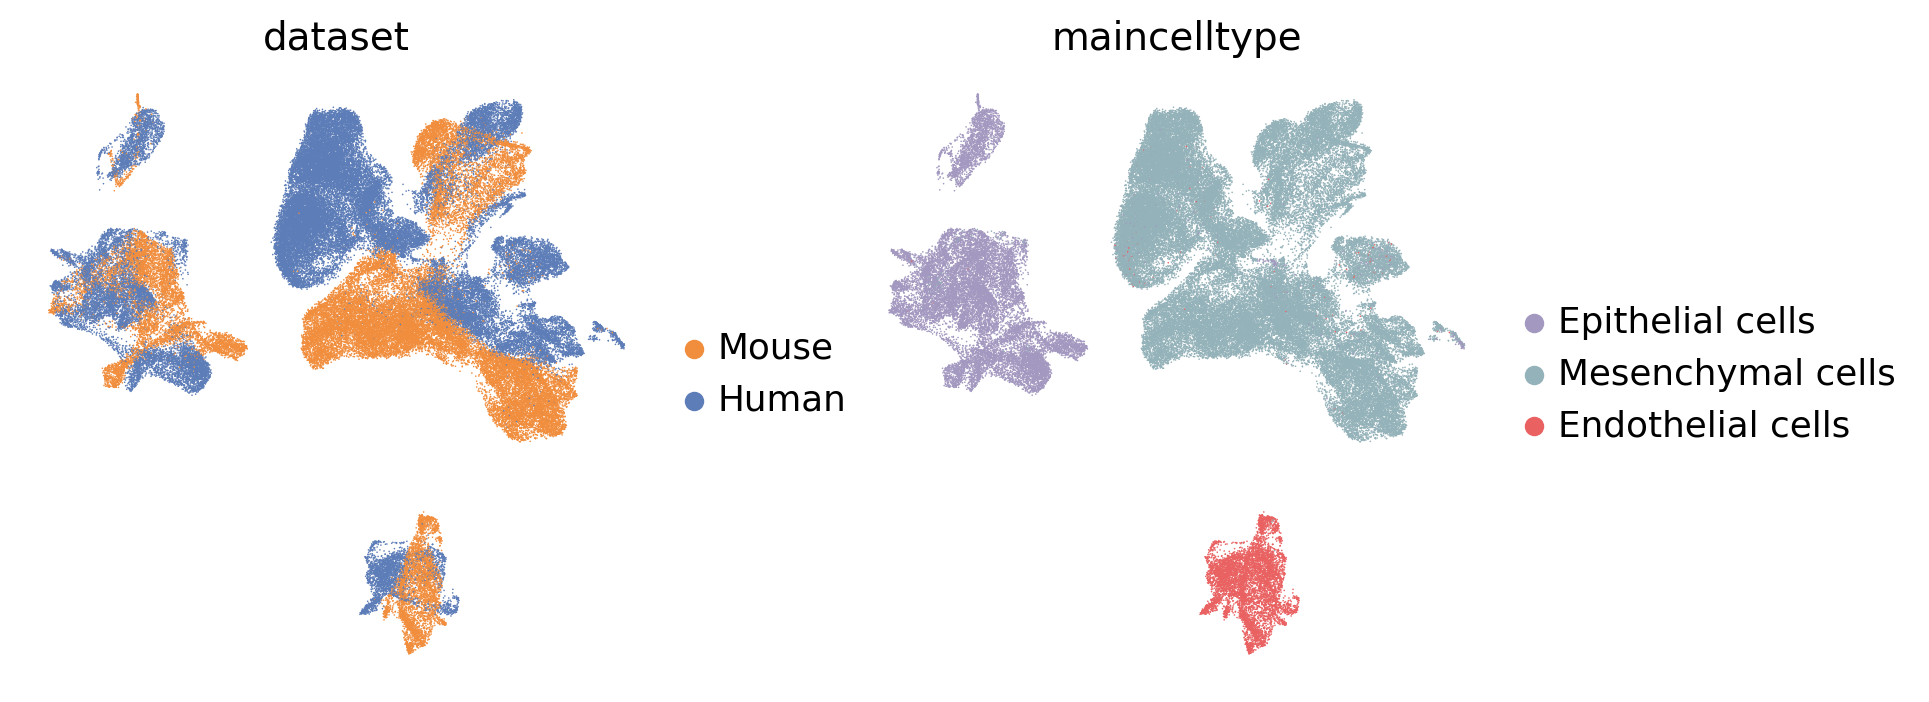

In [10]:
# 4. Visualization
np.random.seed(1)
o=np.random.choice(np.arange(adata.shape[0]), adata.shape[0], replace=False) 
sc.pl.embedding(adata[o],basis = 'X_umap_pca_harmony', color = ['dataset','maincelltype'], frameon=False)

### 2.2 Perform Harmony with CCA

This is the Python implementation of [Seurat CCA](https://doi.org/10.1016/j.cell.2019.05.031). The algorithm can be regarded as dual PCA, and reference can be made to the blog post at https://xinmingtu.cn/blog/2022/CCA_dual_PCA.

In [11]:
# 1. Perform CCA
key = 'dataset'
adata = de.runCCA(adata, adata.obs[key]=='Human',adata.obs[key]=='Mouse', use_rep=None,features= None,n_components=40) # 40 CCA conponent

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Receiv

In [12]:
# 2. Perform harmony integration.
sce.pp.harmony_integrate(adata, key, basis = 'X_cca', adjusted_basis = 'X_cca_harmony')

2025-11-29 16:31:24,864 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-29 16:31:54,231 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-29 16:31:55,018 - harmonypy - INFO - Iteration 1 of 10
2025-11-29 16:33:40,600 - harmonypy - INFO - Iteration 2 of 10
2025-11-29 16:35:26,797 - harmonypy - INFO - Iteration 3 of 10
2025-11-29 16:37:14,897 - harmonypy - INFO - Iteration 4 of 10
2025-11-29 16:38:19,001 - harmonypy - INFO - Iteration 5 of 10
2025-11-29 16:39:07,199 - harmonypy - INFO - Iteration 6 of 10
2025-11-29 16:39:57,000 - harmonypy - INFO - Iteration 7 of 10
2025-11-29 16:40:42,609 - harmonypy - INFO - Iteration 8 of 10
2025-11-29 16:41:22,392 - harmonypy - INFO - Iteration 9 of 10
2025-11-29 16:42:02,298 - harmonypy - INFO - Iteration 10 of 10
2025-11-29 16:42:42,191 - harmonypy - INFO - Stopped before convergence


In [13]:
# 3. Perform UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, use_rep = 'X_cca_harmony')
sc.tl.umap(adata)
adata.obsm['X_umap_cca_harmony'] = adata.obsm['X_umap']

In [14]:
## Define the cell colors
adata.obs['dataset'] = pd.Categorical(np.array(adata.obs['dataset']), ['Mouse','Human'])
adata.obs['maincelltype'] = pd.Categorical(np.array(adata.obs['maincelltype']), ['Epithelial cells','Mesenchymal cells','Endothelial cells'])
adata.obs['human_stage'] = pd.Categorical(np.array(adata.obs['human_stage']))
adata.obs['mouse_stage'] = pd.Categorical(np.array(adata.obs['mouse_stage']))

adata.uns['dataset_colors'] = ['#F18E3D', '#5D7DB8']
adata.uns['maincelltype_colors'] = ['#A398C0', '#94B2B9', '#E96161']
adata.uns['human_stage_colors'] = ['#224298', '#2164ab', '#2489ba', '#38a8c1', '#5fc0bf', '#90d4ba','#c1e7b5', '#e4f4b5']
adata.uns['mouse_stage_colors'] = ['#3e78b6', '#3e94b7', '#56b0ac', '#71c6a5', '#91d3a4', '#b1dfa2',
                                    '#cdeb9d', '#e7f59c', '#f4faad', '#fdfcb9', '#fef0a6', '#fee08e',
                                    '#feca78', '#fdb165', '#fa9556', '#f57748', '#ea5d47', '#da464c',
                                    '#c42c4b']

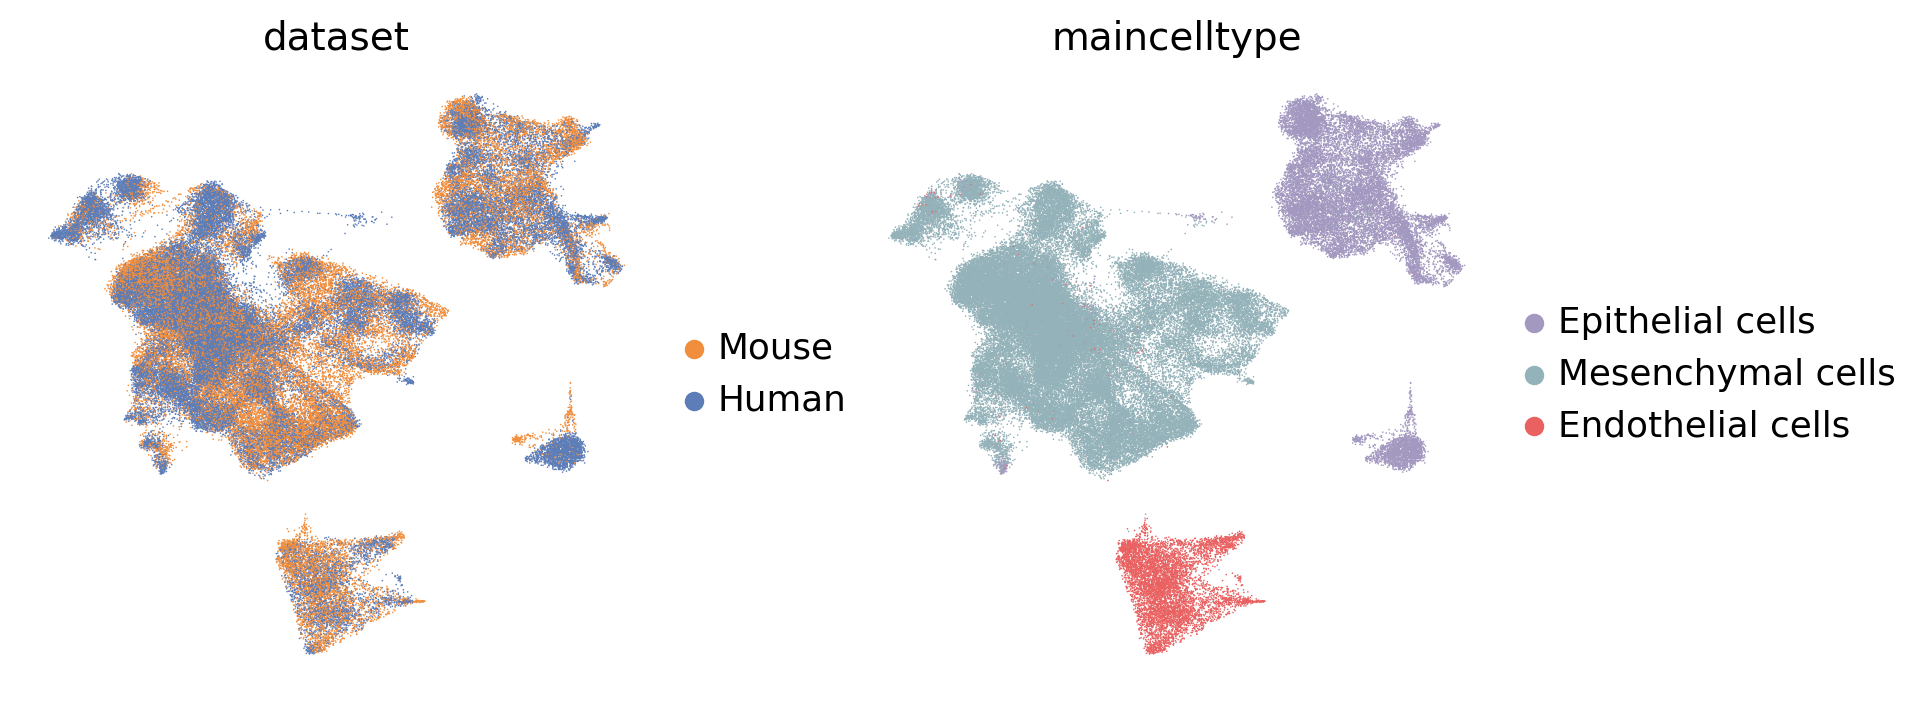

In [15]:
# 4. Visualization
np.random.seed(1)
o=np.random.choice(np.arange(adata.shape[0]), adata.shape[0], replace=False) 
sc.pl.embedding(adata[o],basis = 'X_umap_cca_harmony', color = ['dataset','maincelltype'], frameon=False)

Since minor parameter variations can alter the layout, the layout presented in the original study can be found in adata.obsm['X_umap_cca_harmony_raw'].

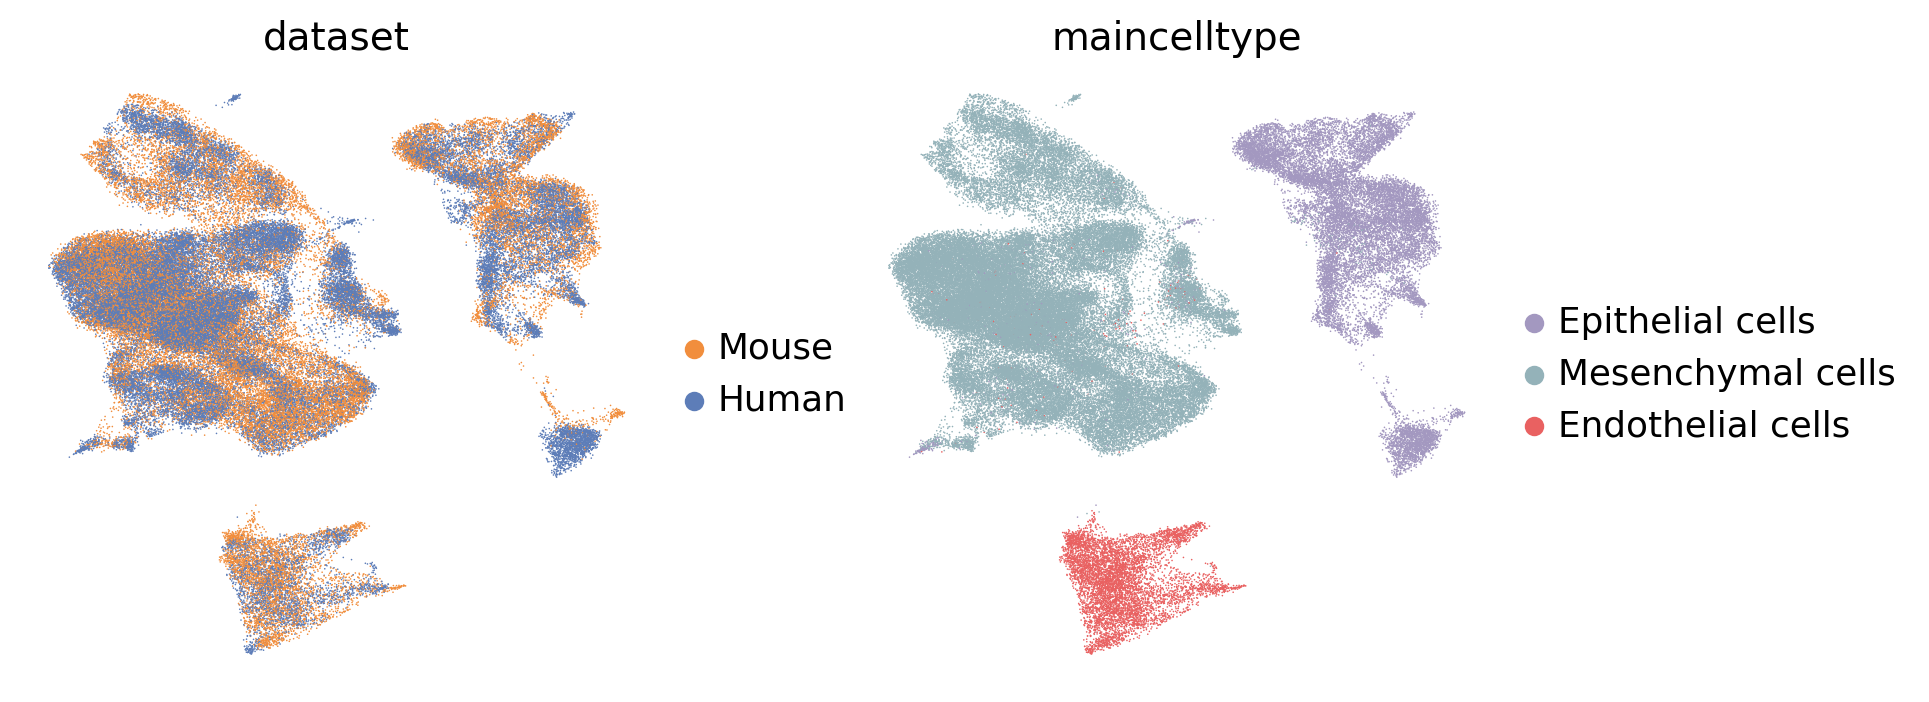

In [16]:
# 4. Visualization
np.random.seed(1)
o=np.random.choice(np.arange(adata.shape[0]), adata.shape[0], replace=False) 
sc.pl.embedding(adata[o],basis = 'X_umap_cca_harmony_raw', color = ['dataset','maincelltype'], frameon=False)

## 3. Evaluate the integration performance

We now use [Single-cell integration benchmarking (scIB)](https://doi.org/10.1038/s41592-021-01336-8) to evaluate the results from different strategies.

### 3.1 kBET metric

The kBET algorithm determines whether the label composition of a k nearest neighborhood of a cell is similar to the expected (global) label composition. The scaled kBET score, 0 meaning low batch mixing and 1 meaning optimal batch mixing。

In [17]:
import os
os.environ['R_HOME'] = "/share/home/lhlin/.conda/envs/scib/lib/R" # Make sure that rpy2 is installed properly
import scib

Due to the large number of cells in this dataset, the kBET analysis take long time to run (more than 1hrs per dataset). The speed up this process, I random choice 5000 cells for calculation.

In [18]:
np.random.seed(1)
n = 5000
o=np.random.choice(np.arange(adata.shape[0]), n, replace=False) 

Here, different embeddings were used as inputs for evaluation: X_pca represents the unintegrated scenario, X_pca_harmony denotes the original integration pipeline of the Harmony method, and X_cca_harmony corresponds to the CCA+Harmony integration pipeline.

In [19]:
kBET = pd.DataFrame()
for emb in ['X_pca','X_pca_harmony','X_cca_harmony']:
    print(emb)
    kBET.loc[emb, "value"]= scib.metrics.kBET(
                                adata[o],
                                batch_key='dataset',
                                label_key='maincelltype',
                                type_="full", ## for equal treatment
                                embed = emb,
                                scaled=True,
                                return_df=False,
                                verbose=True,
                            )

X_pca
batch: dataset
0 labels consist of a single batch or is too small. Skip.
Use 70 nearest neighbors.
Adding diffusion to step 4
importing expression matrix
kBET estimation
Number of kBET tests is set to 103.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Use 70 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 359.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Use 49 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 40.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


X_pca_harmony
batch: dataset
0 labels consist of a single batch or is too small. Skip.
Use 70 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 103.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Use 70 nearest neighbors.
Adding diffusion to step 4
importing expression matrix
kBET estimation
Number of kBET tests is set to 359.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Use 49 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 40.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


X_cca_harmony
batch: dataset
0 labels consist of a single batch or is too small. Skip.
Use 70 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 103.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Use 70 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 359.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Use 49 nearest neighbors.
Adding diffusion to step 4
importing expression matrix
kBET estimation
Number of kBET tests is set to 40.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


### 3.2 NMI metirc

The normalized mutual information (NMI) is a modified mutual information (MI) accounting for the entropies of clustering assignments and ground truth labels (e.g., cell type). Ranging from 0 to 1 (0 = no information overlap, 1 = perfect alignment), NMI effectively assesses overcorrection in batch processing: overcorrection obscures biological signals, leading to low NMI scores.

In [20]:
NMI = pd.DataFrame()
for emb in ['X_pca','X_pca_harmony','X_cca_harmony']:
    print(emb)
    sub_adata = adata.copy()
    scib.me.cluster_optimal_resolution(
        sub_adata,
        cluster_key="cluster",
        label_key='maincelltype',
        use_rep = emb,
        cluster_function=sc.tl.leiden,
    )
    NMI.loc[emb, "value"]= scib.me.nmi(
        sub_adata, cluster_key="cluster", label_key='maincelltype'
    )

X_pca
Recompute neighbors on rep X_pca instead of X_cca_harmony
Cluster for cluster_0.2 with leiden


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)


resolution: 0.2, nmi: 0.4364698449280945
Cluster for cluster_0.4 with leiden
resolution: 0.4, nmi: 0.4046423151862769
Cluster for cluster_0.6 with leiden
resolution: 0.6, nmi: 0.39256884427049465
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.3746100232807478
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.36855265352867167
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.36106551679635734
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.35397257417647304
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.34133415895831426
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.32977232122621875
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.3253870079691185
optimised clustering against maincelltype
optimal cluster resolution: 0.2
optimal score: 0.4364698449280945
X_pca_harmony
Recompute neighbors on rep X_pca_harmony instead of X_cca_harmony
Cluster for cluster_0.2 with leiden
resolution: 0.2, nmi: 0.498257063863

In [21]:
kBET

,value
X_pca,0.27
X_pca_harmony,0.57
X_cca_harmony,0.77


In [22]:
NMI

,value
X_pca,0.44
X_pca_harmony,0.50
X_cca_harmony,0.56


## 4. Predict developmental stage

In [23]:
mouse = adata[adata.obs['dataset'] == 'Mouse']
human = adata[adata.obs['dataset'] == 'Human']

Find the mouse cells that are the nearest neighbors of human cells and assign the developmental stages of the mouse cells to the human cells.

In [24]:
predict_labels = 'mouse_stage'
mouse_emb = pd.DataFrame(mouse.obsm['X_cca_harmony'], index = mouse.obs_names)
human_emb = pd.DataFrame(human.obsm['X_cca_harmony'], index = human.obs_names)

knn = de.fastKnn(mouse_emb, human_emb,n_neighbors=1)
mapping = pd.Series([mouse_emb.index[i] for i in knn[1][:,0]], index = human_emb.index.values)

anno = mouse.obs.loc[mapping.values,predict_labels]
human.obs[predict_labels] = anno.values

/tmp/ipykernel_51530/2434754169.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  human.obs[predict_labels] = anno.values


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  # Albeit hashmap has O(1) look-up (vs. O(logn) in sorted array),
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  # Albeit hashmap has O(1) look-up (vs. O(logn) in sorted array),
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdoc

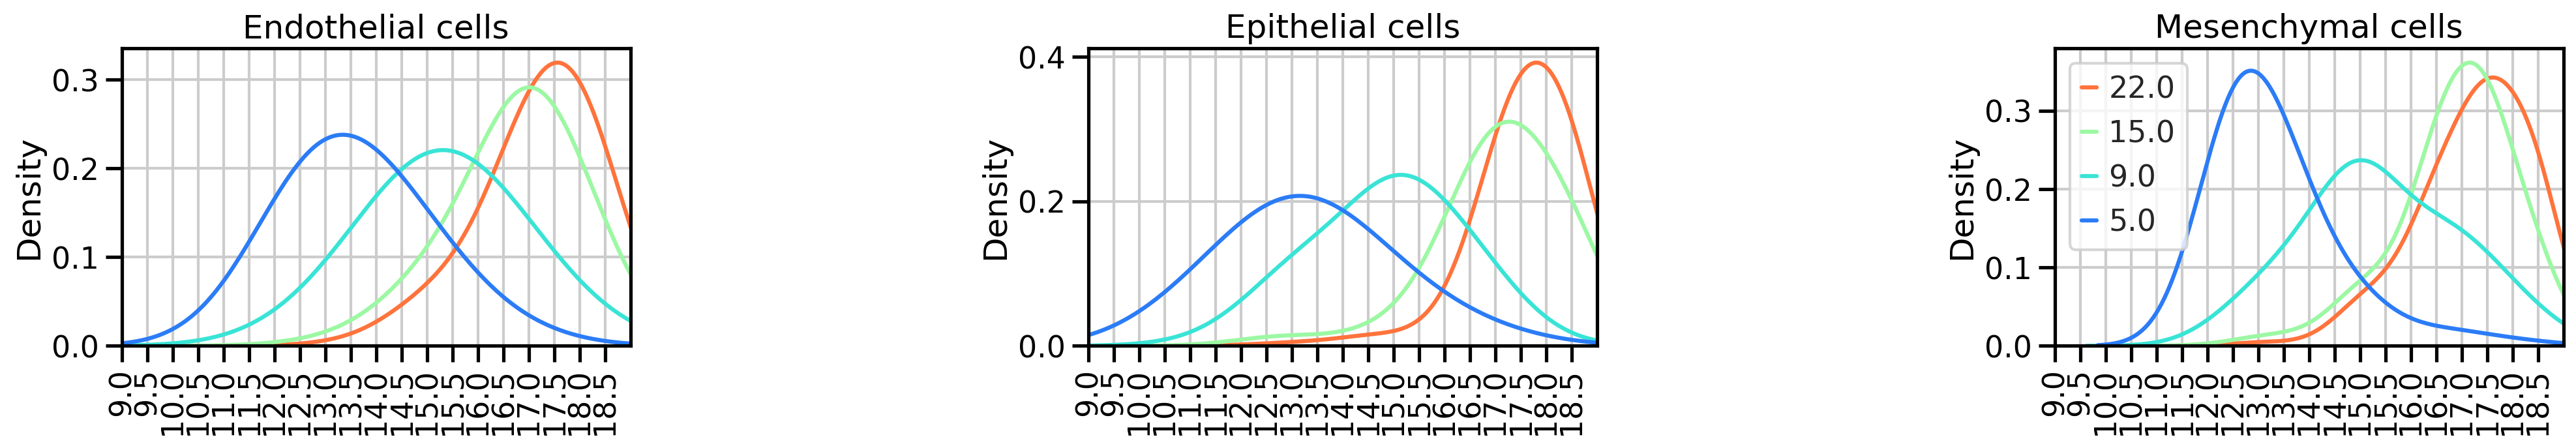

In [25]:
# species = 'Human'
palette = 'rainbow_r'
bw = 3
color_anno = {5.0: '#2b7cf6',
 6.86: '#1ab8e9',
 9.0: '#39e4d6',
 11.0: '#6af9bf',
 15.0: '#9cf8a3',
 18.0: '#cddf84',
 20.0: '#f4b161',
 22.0: '#ff733c'}

celltypes = ['Endothelial cells','Epithelial cells','Mesenchymal cells']
fig, axs = plt.subplots(1, len(celltypes), figsize=(24,3), gridspec_kw={'wspace':0.9})
for celltype in celltypes:
    ax = axs[celltypes.index(celltype)]
    ax.set_title(celltype)
    df_val = human[human.obs['maincelltype'] == celltype].obs

    for i in range(len(df_val['human_stage'].cat.categories)):
        stage = df_val['human_stage'].cat.categories[::-1][i]
        if stage in [5.0,9.0,15.0,22.0]:
            df = df_val[df_val['human_stage'] == stage]
            g = sns.kdeplot(data=df[predict_labels].to_numpy(), bw_adjust=bw,color=color_anno[stage],ax = ax,label =stage)
            g.set(xticks=np.arange(9.0,19.0,0.5))
            g.set_xticklabels(np.arange(9.0,19.0,0.5), rotation=90)
            g.set(xlim=(9.0, 19.0))
            sns.set_style("white")
            
plt.legend()
plt.show()

/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/devendo.py:1377: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_adata.obs[stage_label] = np.array(sub_adata.obs[stage_label])
/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/devendo.py:1394: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_adata.obs[stage_label] = np.array(sub_adata.obs[stage_label])
/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/devendo.py:1377: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_adata.obs[stage_label] = np.array(sub_adata.obs[stage_label])
/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/devendo.py:1394: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_adata.obs[stage_label] = np.array(sub_adata.obs[stage_label])
/share/home/lhlin/worksp

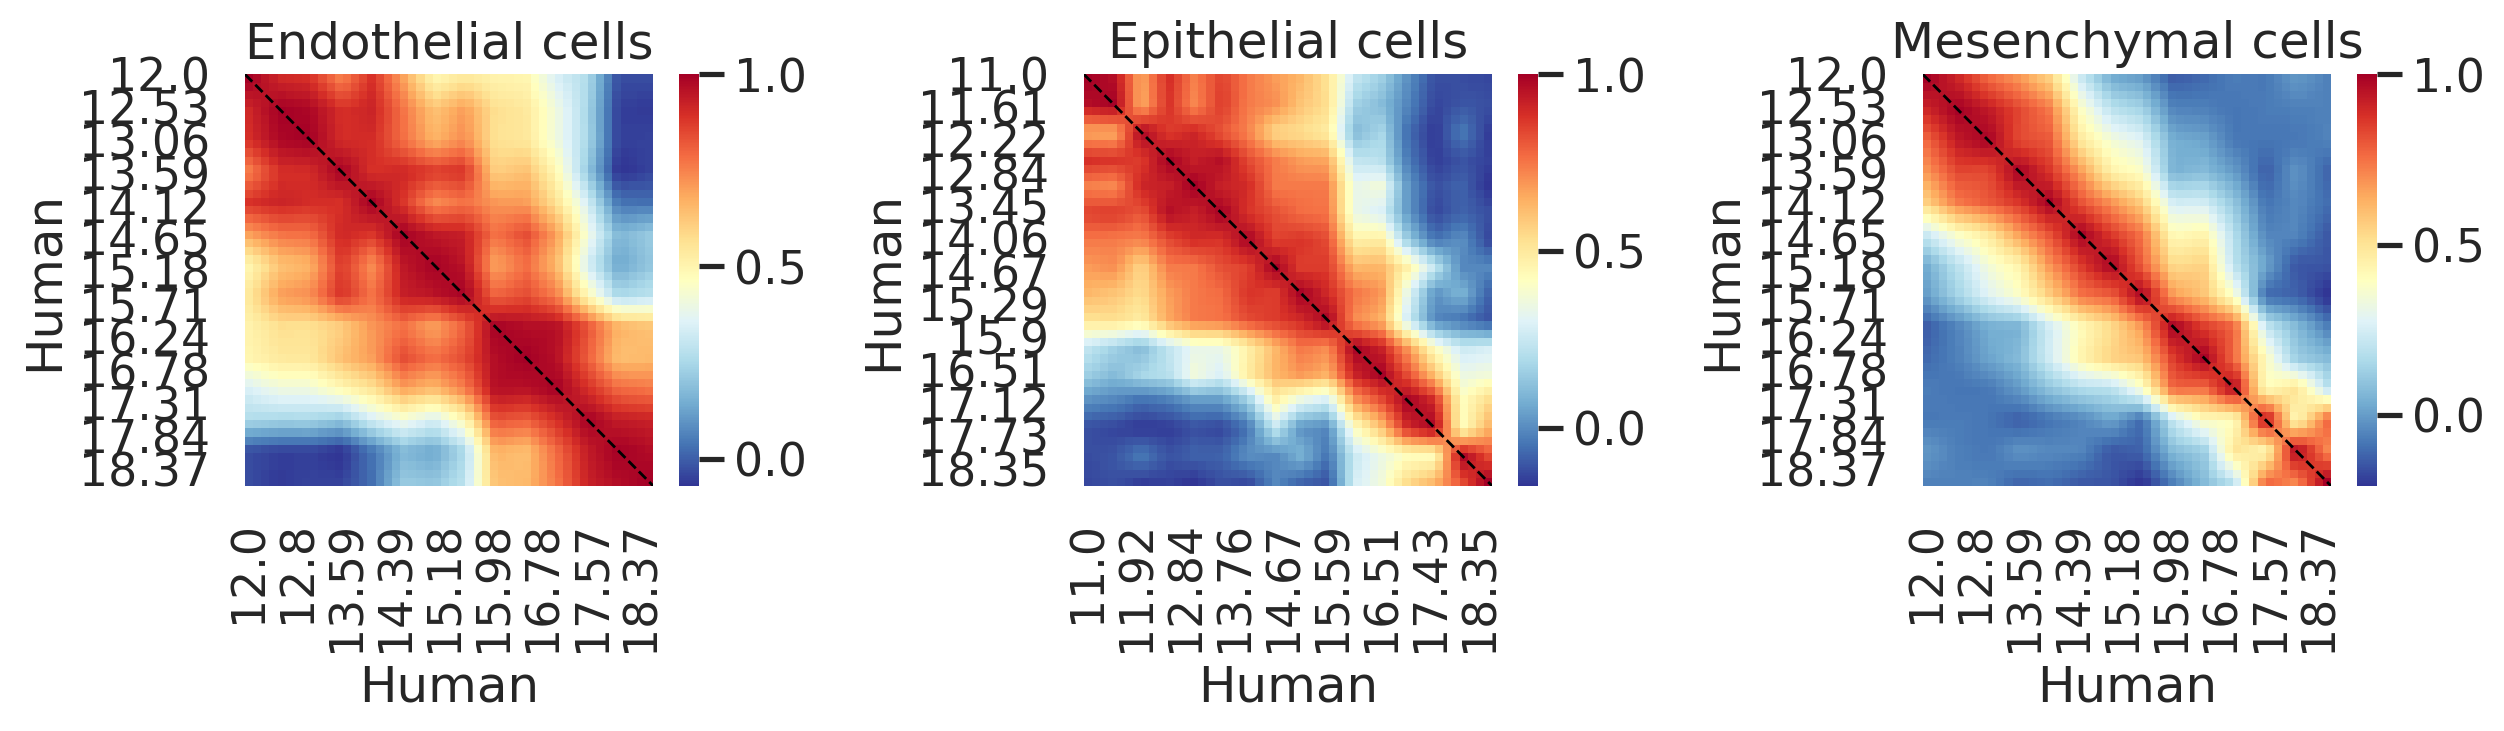

In [26]:
celltypes = ['Endothelial cells','Epithelial cells','Mesenchymal cells']
fig, axs = plt.subplots(1, 3,figsize = (13,4))
for i in range(len(celltypes)):
    sub_adata = human[(human.obs['maincelltype'] == celltypes[i])]
    # sub_adata = de.oneStepUmap(sub_adata, umap = False, resolution = None)
    de.compareSpeciesStage(sub_adata,basis='X_cca_harmony', cmap = 'RdYlBu_r',title = celltypes[i],ax=axs[i],
                           metric='similarity',stage_label = 'mouse_stage', condition_label = 'dataset', condition1 = 'Human', condition2 = 'Human', num = 50)
plt.tight_layout(h_pad=0.8)

/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/devendo.py:1377: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_adata.obs[stage_label] = np.array(sub_adata.obs[stage_label])
/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/devendo.py:1394: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_adata.obs[stage_label] = np.array(sub_adata.obs[stage_label])
/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/devendo.py:1377: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_adata.obs[stage_label] = np.array(sub_adata.obs[stage_label])
/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/devendo.py:1394: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub_adata.obs[stage_label] = np.array(sub_adata.obs[stage_label])
/share/home/lhlin/worksp

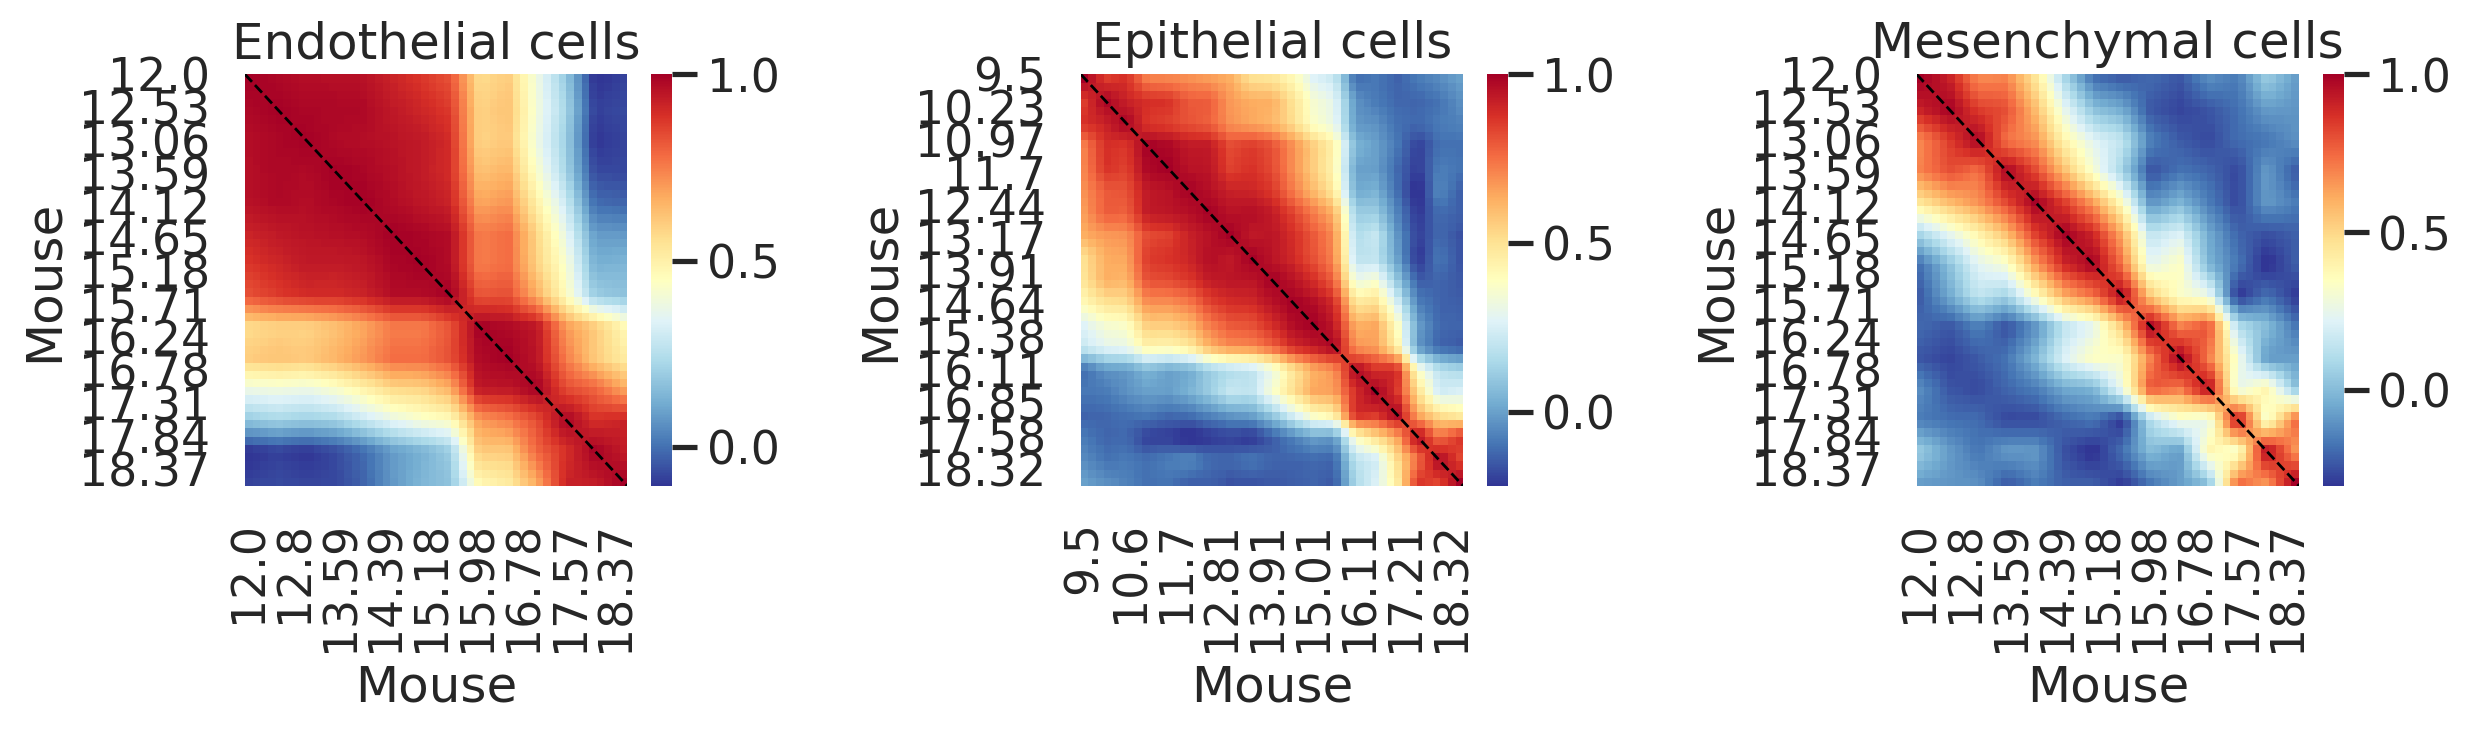

In [27]:
celltypes = ['Endothelial cells','Epithelial cells','Mesenchymal cells']
fig, axs = plt.subplots(1, 3,figsize = (13,4))
for i in range(len(celltypes)):
    sub_adata = mouse[(mouse.obs['maincelltype'] == celltypes[i])]
    # sub_adata = de.oneStepUmap(sub_adata, umap = False, resolution = None)
    de.compareSpeciesStage(sub_adata,basis='X_cca_harmony', cmap = 'RdYlBu_r',title = celltypes[i],ax=axs[i],
                           metric='similarity',stage_label = 'mouse_stage', condition_label = 'dataset', condition1 = 'Mouse', condition2 = 'Mouse', num = 50)
plt.tight_layout(h_pad=0.8)